In [1]:
import sympy as sy
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.integrate import quad
%matplotlib inline

# Gradients of expectations


- https://gregorygundersen.com/blog/2018/04/29/reparameterization/
- https://ermongroup.github.io/cs228-notes/
- https://ermongroup.github.io/cs228-notes/extras/vae/
- https://stats.stackexchange.com/questions/199605/how-does-the-reparameterization-trick-for-vaes-work-and-why-is-it-important


**OUR GOAL**: We want to maximize an expectation of a function with respect to a probability distribution

**OUR PLAN**: Obtain the gradient of the expectation and minimize

**REPARAMETRIZATION TRICK**: (according to [here](http://blog.shakirm.com/2015/10/machine-learning-trick-of-the-day-4-reparameterisation-tricks/) ) the substitution of a random variable by a deterministic transformation of a simpler random variable.


## Computing an expectation

recall the montecarlo aproximation of an expectation

$$
\begin{align}
\mathbb{E}_{z\sim p(z)} \big[f(z)\big] &= \int_0^\infty p(z)f(z) dz & (1)\\
&\approx \frac{1}{N}\sum_{z_i \sim p(z)}^N f(z_i)  & (2)
\end{align}
$$

we check it with a custom distribution, and any $f(z)$:

- $z \in [1, 2]$
- $p(z) = m (z-3/2) + 1$, with $m \in [-2,2]$

In [2]:
m, z, r = sy.symbols("m z r")                       # symbols
mn  = -2                                 # a numerical value for m

assert mn!=0 and mn>=-2 and mn<=2

pdf  = m*(z-sy.Integer(3)/sy.Integer(2))+1     # PDF
cdf  = pdf.integrate(z)                        # CDF
cdf = cdf - cdf.subs({z:1})
icdf = sy.solve(cdf-r, z)[1]                     # inverse CDF (for sampling)

# numpy functions for pdf, cdf, inverse cdf
pdfn  = sy.lambdify(z, pdf.subs({m:mn}), "numpy") 
cdfn  = sy.lambdify(z, cdf.subs({m:mn}), "numpy")
icdfn = sy.lambdify(r, icdf.subs({m:mn}), "numpy")

sample = lambda n_samples: icdfn(np.random.random(n_samples))

f  = sy.sin(z)                            # any function (symbolic)
fn = sy.lambdify(z, f, "numpy")                # evaluable

In [3]:
cdf

m*z**2/2 + m + z*(1 - 3*m/2) - 1

In [4]:
# pdf, cdf
sy.Matrix([pdf.subs({m:mn}), cdf.subs({m:mn}), icdf.subs({m:mn})])

Matrix([
[              4 - 2*z],
[      -z**2 + 4*z - 3],
[2 - sqrt(16 - 16*r)/4]])

sanity checks

In [5]:
np.allclose(cdfn(2), 1)  # CDF at 1 is 1

True

In [6]:
cdfn(2), cdfn(1)

(1, 0)

In [7]:
# inverse CDF works
rr = np.linspace(0,1,100)
np.allclose(cdfn(icdfn(rr)), rr)

True

In [8]:
zr = np.linspace(1,2,100)
np.allclose(icdfn(cdfn(zr)), zr)

True

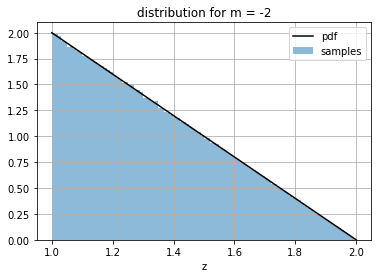

In [9]:
# sampling histogram corresponds to pdf

zr = np.linspace(1,2,100)
s = sample(1000000)
plt.hist(s, bins=100, density=True, alpha=0.5, label="samples");
plt.plot(zr, pdfn(zr), color="black", label="pdf")
plt.title(f"distribution for m = {mn}")
plt.xlabel("z")
plt.grid();
plt.legend();

compute eq (1) above

In [10]:
expectation_integral = sy.integrate(pdf.subs({m: mn})*f, z)
expectation_integral = expectation_integral.subs({z:2}) - expectation_integral.subs({z:1})
sy.N(expectation_integral)


0.944951727700709

montecarlo approximation as eq (2) above

In [11]:
zs = sample(10000)
np.mean(fn(zs))

0.9449006075895808

## Computing an expectation of a parametrized function

Let's have $f(z)$ depending on a parameter $\theta$, and we denote it with $f_\theta(z)$ to emphasize it, for instance


In [12]:
t = sy.symbols(r"\theta")
f = -t**2+2*t
f


-\theta**2 + 2*\theta

the above expectation will naturally become a function of $\theta$

$$
\begin{align}
\mathbb{E}_{z\sim p(z)} \big[f_\theta(z)\big] &= \int p(z)f_\theta(z) dz \\
&\approx \frac{1}{N}\sum_{z_i \sim p(z)}^N f_\theta(z_i)  & (2)
\end{align}
$$

In [13]:
expectation_integral = sy.integrate(pdf.subs({m: mn})*f, z)
expectation_integral = expectation_integral.subs({z:2}) - expectation_integral.subs({z:1})
expectation_integral

-\theta**2 + 2*\theta

observe how the value of the expectation depends on the parameter $\theta$ (and the probability $p(z)$)

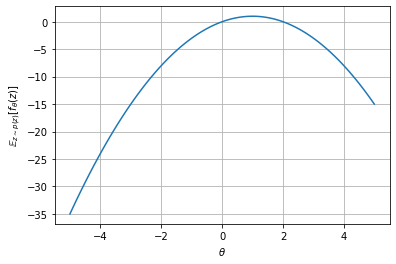

In [14]:
t_range = np.linspace(-5,5,100)
expectation_integral_fn = sy.lambdify(t, expectation_integral, "numpy")

plt.plot(t_range, expectation_integral_fn(t_range))
plt.xlabel(r"$\theta$")
plt.ylabel(r"$\mathbb{E}_{z\sim p(z)} [f_\theta(z)] $");
plt.grid();

which we can evaluate for a specific value of $\theta$, directly on the analytic integral, or with the montecarlo simulation

In [15]:
t_val = -1
sy.N(expectation_integral.subs({t: t_val }))

-3.00000000000000

In [16]:
fn = sy.lambdify(z, f.subs({t: t_val}), "numpy")
np.mean(fn(zs))

-3.0

## Computing the gradient of an expectation

so we can ask for its gradient (which must be with respect to the parameter $\theta$).

The gradient naturally slips into the integral, or the montecarlo approximation sum (the derivative of a sum is the sum of the derivatives)

$$
\begin{align}
\nabla_\theta \mathbb{E}_{p_z(z)}[f_\theta(z)] &= \nabla_\theta \Big[\int p_z(z) f_\theta(z)dz\Big]\\
&= \int \nabla_\theta \Big[ p_z(z) f_\theta(z)\Big] dz &\;\;\;\;\;(1)\\
&= \int p_z(z) \nabla_\theta \Big[ f_\theta(z)\Big] dz &\;\;\;\;\;(2)
\end{align}
$$

$$
\begin{align}
\nabla_\theta \mathbb{E}_{p_z(z)}[f_\theta(z)] &\approx \nabla_\theta \Big[ \frac{1}{N}\sum_{z_i \sim p(z)}^N f_\theta(z_i) \Big] & &\;\;\;\;\;(3)\\
&=   \frac{1}{N}\sum_{z_i \sim p(z)}^N \nabla_\theta f_\theta(z_i)  & &\;\;\;\;\;(4)\\
\end{align}
$$

**OBSERVATIONS**

- We can take $p_z(z)$ out of $\nabla_\theta$ in $(2)$ because $p_z(z)$ does not depend on $\theta$ so it appears as a constant for $\nabla_\theta$

- Eqs $(1)$ through $(4)$ show that the gradient of this expectation is equal to the expectation of the gradient

- Regularly, in ML, a loss function is defined in terms of each data point in a mini-batch and then averaged:

$$\mathcal{L}_\theta = \frac{1}{N}\sum_i^N l_\theta(x^{(i)})$$

where $\theta$ are the model parameters. We then use the gradient of the loss function to optimize

$$\nabla_\theta \mathcal {L}_\theta = \frac{1}{N}\sum_i^N \nabla_\theta l_\theta(x^{(i)})$$

which is analogous to eq. $(4)$ except that we are not explicitly sampling from a known or target distribution, but using the samples on the dataset available. So **what we are doing is not specially new**.


In [17]:
f = -t**2+2*t


In [18]:
# equation (1)
grad_expectation_integral = sy.integrate((pdf.subs({m: mn})*f).diff(t), z)
grad_expectation_integral = grad_expectation_integral.subs({z:2}) - grad_expectation_integral.subs({z:1})
grad_expectation_integral

2 - 2*\theta

In [19]:
# equation (2)
grad_expectation_integral = sy.integrate(pdf.subs({m: mn})*f.diff(t), z)
grad_expectation_integral = grad_expectation_integral.subs({z:2}) - grad_expectation_integral.subs({z:1})
grad_expectation_integral

2 - 2*\theta

In [20]:
sy.N(grad_expectation_integral.subs({t: t_val }))

4.00000000000000

In [21]:
# equation (3), takes a long time, since it must differentiate a long sum (one term per sample)
sum([f.subs({z:zi}) for zi in zs]).diff(t).subs({t: t_val})/len(zs)

4

In [22]:
# equation (4) 
dfn = sy.lambdify(z, f.diff(t).subs({t: t_val}), "numpy")
np.mean(dfn(zs))

4.0

## Maximizing the expectation

since we have a gradient we can get the maximum. In this simple case, we can solving analyticaly, we do not need gradient descent/ascent

In [521]:
t_max = sy.solve(grad_expectation_integral, t)[0]
t_max

1

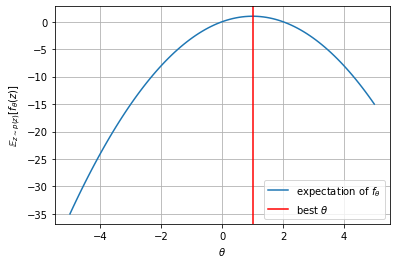

In [522]:
plt.plot(t_range, expectation_integral_fn(t_range), label=r"expectation of $f_\theta$")
plt.axvline(t_max, color="red", label=r"best $\theta$")
plt.grid();
plt.legend();
plt.xlabel(r"$\theta$")
plt.ylabel(r"$\mathbb{E}_{z\sim p(z)} [f_\theta(z)] $");

### Now, $p(z)$ is also parametrized by $\theta$

In [702]:
t = sy.symbols(r"\theta")
f = t**2
#f = sy.sin(t)

In [703]:
f

\theta**2

In [704]:
mt = sy.sin(t)
expectation_integral = sy.integrate(pdf.subs({m: mt})*f, z)
expectation_integral = (expectation_integral.subs({z:2}) - expectation_integral.subs({z:0})).simplify()
expectation_integral

\theta**2*(2 - sin(\theta))

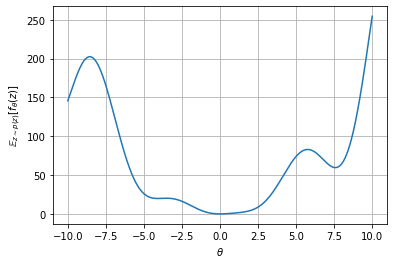

In [705]:
tr = np.linspace(-10,10,1000)
expectation_integral_fn = sy.lambdify(t, expectation_integral, "numpy")

plt.plot(tr, expectation_integral_fn(tr))
plt.xlabel(r"$\theta$")
plt.ylabel(r"$\mathbb{E}_{z\sim p(z)} [f_\theta(z)] $");
plt.grid();

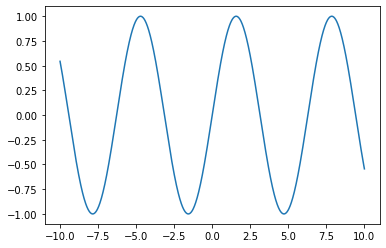

In [706]:
mtn = sy.lambdify(t,mt, "numpy")
plt.plot(tr, mtn(tr))

In [707]:
f

\theta**2

In [708]:
# equation (1)
grad_expectation_integral = sy.integrate((pdf.subs({m: mt})*f).diff(t), z)
grad_expectation_integral = grad_expectation_integral.subs({z:2}) - grad_expectation_integral.subs({z:1})
grad_expectation_integral

2*\theta

In [709]:
# equation (2)
grad_expectation_integral = sy.integrate(pdf.subs({m: mt})*f.diff(t), z)
grad_expectation_integral = grad_expectation_integral.subs({z:2}) - grad_expectation_integral.subs({z:1})
grad_expectation_integral

2*\theta

In [712]:
sy.integrate((pdf.subs({m: mt})*f).diff(t),z)

z**2*(\theta**2*cos(\theta)/2 + \theta*sin(\theta)) + z*(-3*\theta**2*cos(\theta)/2 - 3*\theta*sin(\theta) + 2*\theta)

In [715]:
k = sy.integrate(pdf.subs({m: mt})*f.diff(t), z)
k

\theta*z**2*sin(\theta) + z*(-3*\theta*sin(\theta) + 2*\theta)

In [716]:
k.subs({z:2})- k.subs({z:1})

2*\theta